<a href="https://colab.research.google.com/github/guptavishu1000/langgraph-crash-course/blob/main/7_langsmith_tracing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph langchain google-genai python-dotenv
!pip install -U langchain-google-genai

In [2]:
from google.colab import userdata
import os

# Load the secret key into an environment variable
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [3]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
from dotenv import load_dotenv
load_dotenv()

False

In [5]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [6]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

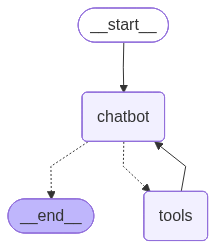

In [7]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]})
    return state["messages"][-1].content

call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?")

'The current price for AMZN is $150 and for MSFT is $200.3.\nThe total cost for 20 AMZN stocks is 20 * $150 = $3000.\nThe total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.\nTherefore, the total cost for both is $3000 + $3004.5 = $6004.5.'